# 가위, 바위, 보!
가위바위보 이미지 데이터셋를 이용해 가위, 바위, 보를 분류해보자
- [Teachable Machine](https://teachablemachine.withgoogle.com/) 사이트에서 직접 데이터셋 생성
- 데이터셋 모음(아이펠 교육생 데이터)[가위바위보 데이터셋](https://www.notion.so/modulabs/E-1-7fbdccfc3f2a453c8cf1670c2e76b7c8)
- Pytorch를 이용해 딥러닝 모델 구축

In [1]:
import os
import glob
import random

import torch
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

pont_path =  'C:\\WINDOWS\\Fonts\\HANDotumB.ttf'
fontprop = fm.FontProperties(fname=pont_path, size=18)

from PIL import Image

In [16]:
from torch.utils.tensorboard import SummaryWriter

# 0. 데이터 확인
- 다른 교육생들과 공유하여 데이터양 Up
- 224x224 이미지를 28x28로 Resize(컬러이미지, Channel = 3)
- 교육생 8명을 학습데이터, 다른 교육생 7명을 테스트 데이터로 사용

In [2]:
base_dir = os.path.join('C:\\Users\\gjust\\Documents\\Github', 'data/rock_scissor_paper2')
classes = ['rock', 'scissor', 'paper'] 
train_list = ['사공', '수완', '호성','승민','재성', '지윤', '은서', '정식'] # 8명
test_list = ['민지', '범진', '보경', '영민', '은영', '재준', '효정'] # 7명

print('Name (rock, scissor, paper)')

print('*' * 4, 'Train Dataset', '*' * 8)
for name in train_list: # 이름별 폴더에 하나씩 입장한 후 각 클래스별 개수 count
    len_rock = len(glob.glob(os.path.join(base_dir, name, 'rock/*.jpg')))
    len_scissor = len(glob.glob(os.path.join(base_dir, name, 'scissor/*.jpg')))
    len_paper = len(glob.glob(os.path.join(base_dir, name, 'paper/*.jpg')))
    print(name, (len_rock, len_scissor, len_paper))

print('*' * 4, 'Test Dataset', '*' * 8)
for name in test_list: # 이름별 폴더에 하나씩 입장한 후 각 클래스별 개수 count
    len_rock = len(glob.glob(os.path.join(base_dir, name, 'rock/*.jpg')))
    len_scissor = len(glob.glob(os.path.join(base_dir, name, 'scissor/*.jpg')))
    len_paper = len(glob.glob(os.path.join(base_dir, name, 'paper/*.jpg')))
    
    print(name, (len_rock, len_scissor, len_paper))

Name (rock, scissor, paper)
**** Train Dataset ********
사공 (122, 111, 117)
수완 (101, 102, 102)
호성 (100, 100, 100)
승민 (100, 100, 100)
재성 (100, 100, 100)
지윤 (100, 100, 100)
은서 (103, 101, 103)
정식 (106, 113, 105)
**** Test Dataset ********
민지 (100, 100, 100)
범진 (100, 100, 100)
보경 (100, 100, 100)
영민 (100, 100, 100)
은영 (100, 100, 100)
재준 (100, 100, 100)
효정 (101, 101, 101)


### 0-1. 데이터 확인 : 시각화

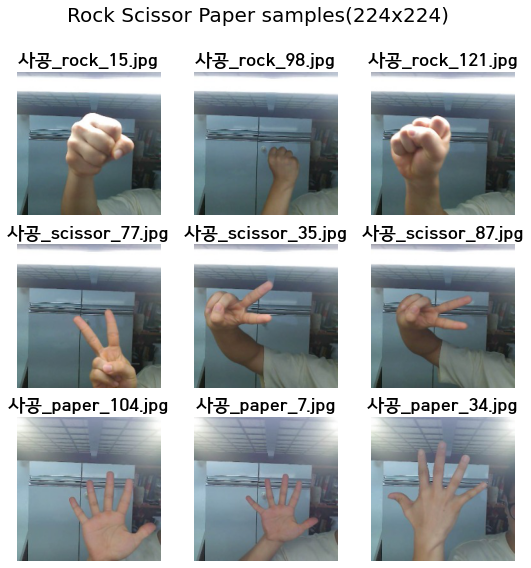

In [3]:
def get_image_sample(name, cls, sample=3):
    image_dir = os.path.join(base_dir, name, cls)
    image_list = glob.glob(image_dir + '/*.jpg')
    
    samples = random.sample(image_list, sample)
    
    return samples

rock_samples = get_image_sample('사공', 'rock')
scissor_samples = get_image_sample('사공', 'scissor')
paper_samples = get_image_sample('사공', 'paper')

sample_list = rock_samples + scissor_samples + paper_samples

plt.figure(figsize=(9,9))
plt.suptitle('Rock Scissor Paper samples(224x224)', fontsize=20)
for i, image_path in enumerate(sample_list):
    image = Image.open(image_path)
    filename = image_path.split('\\')[-1]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(filename, fontproperties=fontprop)
    plt.axis('off')

# 1. 데이터 전처리 및 불러오기

### Train과 Test의 Path 저장

In [4]:
train_list = ['사공', '수완', '호성','승민','재성', '지윤', '은서', '정식']
test_list = ['민지', '범진', '보경', '영민', '은영', '재준', '효정']

train_image_list, train_label_list = [], []
test_image_list, test_label_list = [], []

classes = ['rock', 'scissor', 'paper'] 
cls_to_dict = {'rock': 0, 'scissor': 1, 'paper': 2}

base_dir = os.path.join('C:\\Users\\gjust\\Documents\\Github', 'data/rock_scissor_paper2')

for train_name in train_list:
    train_dir = os.path.join(base_dir, train_name)               
    for cls in classes:
        cls_dir = os.path.join(train_dir, cls)
        cls_image_list = glob.glob(cls_dir + '/*.jpg')
        train_image_list.extend(cls_image_list)
        train_label_list.extend([cls_to_dict[cls]] * len(cls_image_list))

for test_name in test_list:
    test_dir = os.path.join(base_dir, test_name)               
    for cls in classes:
        cls_dir = os.path.join(test_dir, cls)
        cls_image_list = glob.glob(cls_dir + '/*.jpg')
        test_image_list.extend(cls_image_list)
        test_label_list.extend([cls_to_dict[cls]] * len(cls_image_list))

### Dataset 생성

In [5]:
from torch.utils.data import Dataset

class RockScissorPaperDataset(Dataset):
    def __init__(self, path_list, label_list, transform=None):
        self.path_list = path_list
        self.label_list = label_list
        self.transform = transform
        
    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, idx):
        image_path = self.path_list[idx]
        image = Image.open(image_path)
        label = torch.tensor(int(self.label_list[idx]))
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225])])

trainset = RockScissorPaperDataset(path_list=train_image_list,
                                   label_list=train_label_list,
                                   transform=transform)
testset = RockScissorPaperDataset(path_list=test_image_list,
                                   label_list=test_label_list,
                                   transform=transform)

### 데이터 시각화

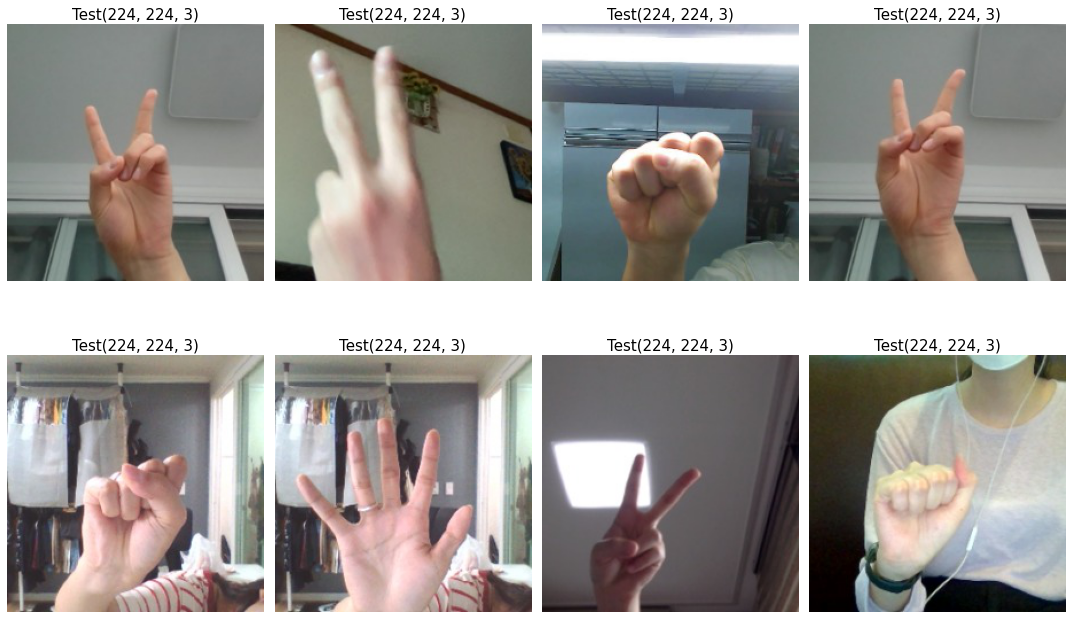

In [7]:
train_show = DataLoader(trainset, shuffle=True, batch_size=4)
test_show = DataLoader(testset, shuffle=True, batch_size=4)

def show_image(train_show, test_show):
    train_img, train_label = iter(train_show).next()
    test_img, test_label = iter(test_show).next()
    
    image_list = np.concatenate([train_img.permute(0,2,3,1), test_img.permute(0,2,3,1)])

    plt.figure(figsize=(15,10))
    for i, image in enumerate(image_list):
        plt.subplot(2,4,i+1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f'Test{image.shape}' if i < 3 else f'Test{image.shape}', fontsize=15)
    
show_image(train_show, test_show)
plt.tight_layout()

# 2. 딥러닝 모델 설계 및 학습
Pytorch API를 이용해 가위바위보를 인식하는 딥러닝 모델을 설계 및 학습
#### 주요특징
- 하이퍼파라미터를 바꿔가면서 성능이 가장 좋은 모델 찾기
- 직접 여러 Layer를 쌓아서 모델 정의
- 과적합(Overfitting) 문제를 해결하기 위해 모델 복잡도 낮추기

In [11]:
# Make Model

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.pool = nn.MaxPool2d(2,2)
    
        self.fc1 = nn.Linear(54 * 54 * 8, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 3)
        
    def forward(self, x): # 224 224
        x = F.relu(self.conv1(x)) # 222 222
        x = self.pool(x)          # 111
        x = F.relu(self.conv2(x)) # 109 109 
        x = self.pool(x)          # 55 55
        x = x.view(-1, 54 * 54 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x   
    
model = Net()

BATCH_SIZE = 8
EPOCH = 10
LR = 0.001

### GPU 사용 여부

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### 컴파일
- 최적화 함수 및 손실함수 정의

In [13]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = LR)
writer = SummaryWriter(f'runs/MNIST/tryingout_tensorboard')
print(loss_func, optimizer)

CrossEntropyLoss() SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Train 및 Test 데이터 생성

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

trainset = RockScissorPaperDataset(path_list=train_image_list,
                                   label_list=train_label_list,
                                   transform=transform)
testset = RockScissorPaperDataset(path_list=test_image_list,
                                   label_list=test_label_list,
                                   transform=transform)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, batch_size=4, shuffle=False)

### 모델 학습

In [142]:
import time

# Train
EPOCH = 10
model.train()
model.to(device)
for e in range(1, EPOCH+1):
    start_time = time.time()
    running_loss = 0
    
        
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss
        now = time.time()
        
        writer.add_scalar('Training Loss', loss, blobal_step=step)
        writer.add_scalar()
        step += 1
        print('\r[%d/%d]-----[%d/%d] LOSS : %.3f------ Time : %d ' 
              %(e, EPOCH, i+1, len(train_loader), running_loss, now - start_time), end = '')        
    print('\n')

[1/10]-----[311/311] LOSS : 340.039------ Time : 4 

[2/10]-----[311/311] LOSS : 334.103------ Time : 4 

[3/10]-----[311/311] LOSS : 317.894------ Time : 4 

[4/10]-----[311/311] LOSS : 262.008------ Time : 4 

[5/10]-----[311/311] LOSS : 165.085------ Time : 4 

[6/10]-----[311/311] LOSS : 101.881------ Time : 4 

[7/10]-----[311/311] LOSS : 67.464------ Time : 4 

[8/10]-----[311/311] LOSS : 45.816------ Time : 4 

[9/10]-----[311/311] LOSS : 33.962------ Time : 4 

[10/10]-----[311/311] LOSS : 32.042------ Time : 4 



In [143]:
model.eval()
model.to(device)
correct = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        val_images, val_labels = data
        
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images)
        pred = val_outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(val_labels.view_as(pred)).sum().item()
        
print('Accuracy of the network on 10000 test images : %.3f %%' %(100 * correct / len(test_loader.dataset)))               

Accuracy of the network on 10000 test images : 29.862 %


# 모두 합친 것

In [13]:
*train_list, test_list = team_list
print(train_list)
print(test_list)

['사공', '수완', '호성', '경은', '승민', '재성', '지윤', '은서']
정식


In [14]:
transform = transforms.Compose([
    #transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

trainset_list = []
for train_name in train_list:
    train_dir = os.path.join(base_dir, train_name)
    trainset = ImageFolder(root=train_dir, transform=transform)
    trainset_list.append(trainset)
test_dir = os.path.join(base_dir, '정식')

trainset = ConcatDataset(trainset_list)
testset = ImageFolder(root=test_dir, transform=transform)


print(len(trainset))
print(len(testset))

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=4)

2462
324


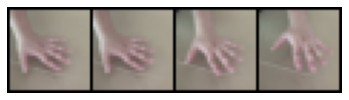

In [7]:
def img_show(dataloader, inv_norm=True):
    images, labels = iter(dataloader).next()

    if inv_norm:
        inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                             std=[1/0.229, 1/0.224, 1/0.225])
        images = inv_normalize(images)

    grid = torchvision.utils.make_grid(images, padding=1)
    grid = grid.permute(1,2,0)
    
    plt.axis('off')
    plt.imshow(grid)

img_show(testloader, inv_norm=True)

In [19]:
# Make Model

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(3 * 3 * 8, 128)
        self.fc3 = nn.Linear(64, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x): # 28 28
        x = F.relu(self.conv1(x)) # 26 26
        x = self.pool(x)          # 13 13
        x = F.relu(self.conv2(x)) # 11 11
        x = self.pool(x)          # 5 5
        x = F.relu(self.conv3(x)) # 3 3
        
        x = x.view(-1, 3 * 3 * 8)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x   
    
model = Net()

In [16]:
import torch.nn as nn
from torchvision import models
vgg = models.vgg16(pretrained=True)

# 모델 고정하기(학습x)
for p in vgg.features.parameters():
    p.requires_grad = False
    
# 출력층 수정하기
vgg.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [20]:
import torch.optim as optim

model = vgg
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)
print(loss_func, optimizer)

CrossEntropyLoss() SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.01
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0.1
)


In [21]:
model.eval()
model.to(device)

with torch.no_grad():
    images, labels = next(iter(trainloader))
    images, labels = images.to(device), labels.to(device)
    
    example = model(images)
    
    print(example.size())
    print('Test : ', example[:5])

torch.Size([32, 3])
Test :  tensor([[ 0.0726, -0.0338,  0.2339],
        [-0.2509, -0.0355,  0.2371],
        [ 0.0925,  0.0868,  0.0208],
        [ 0.2825,  0.0953, -0.1022],
        [ 0.2544, -0.0339,  0.0864]], device='cuda:0')


In [2]:
import time

# Train
def train(EPOCH, model, dataloader, device, loss_func, optimizer):
    print('--------Start Train----------')
    EPOCH = EPOCH
    model.to(device)
    model.train()
    train_loss_list = []
    for e in range(1, EPOCH+1):
        start_time = time.time()
        running_loss = 0

        for i, data in enumerate(dataloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss
            now = time.time()

            print('\r[%d/%d]-----[%d/%d] LOSS : %.3f------ Time : %d ' 
                  %(e, EPOCH, i+1, len(dataloader), running_loss, now - start_time), end = '')        
        train_loss_list.append(running_loss)
        print('\n')
    print('--------Finsh Train----------')
    return train_loss_list

In [17]:
def test(model, dataloader, device, loss_func, confusion_shape=(3,3)):
    print('--------Start Test----------')
    model.eval()
    model.to(device)
    correct = 0
    confusion_matrix = np.zeros(confusion_shape)
    test_loss_list = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            val_images, val_labels = data
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = loss_func(val_outputs, val_labels)
            pred = val_outputs.argmax(dim=1, keepdim=True)
            for i, j in zip(val_labels, pred):
                confusion_matrix[i][j] += 1
            correct += pred.eq(val_labels.view_as(pred)).sum().item()
            test_loss_list.append(loss)
    acc = (100 * correct / len(dataloader.dataset))
    print('Accuracy of the network on 10000 test images : %.3f %%' %(acc))               
    print(confusion_matrix)
    print('--------Finsh Test----------')
    return acc, test_loss_list, confusion_matrix

In [26]:
# Weight 초기화
def weight_init(m):
    if ((type(m) == nn.Conv2d) or (type(m) == nn.Linear)):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)
        
model.apply(weight_init)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=72, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim

np.random.seed(40)
base_dir = os.path.join('C:\\Users\\gjust\\Documents\\Github', 'data', 'rock_scissor_paper2')
classes = ['rock', 'scissor', 'paper']
team_list = ['사공', '수완', '호성', '경은', '승민', \
             '재성', '지윤', '은서', '정식']


transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)


result = {}
best_acc = 0
for i, test_list in enumerate(team_list, start=1):
    model = models.vgg16(pretrained=True)
    for p in model.features.parameters():
        p.requires_grad = False
    model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay=0.1)
    
#     result['try{}'.format(i)] = {}
    print(f'------------------------------try{i}--------------------------------')
    train_list = list(set(team_list) - set([test_list]))
    trainset_list = []
    for train_name in train_list:
        train_dir = os.path.join(base_dir, train_name)
        trainset = ImageFolder(root=train_dir, transform=transform)
        trainset_list.append(trainset)
    test_dir = os.path.join(base_dir, test_list)
#     result['try{}'.format(i)]['train_list'] = train_list
#     result['try{}'.format(i)]['test_list'] = test_list
    
    trainset = ConcatDataset(trainset_list)
    testset = ImageFolder(root=test_dir, transform=transform)


    print(len(trainset))
    print(len(testset))

    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    testloader = DataLoader(testset, batch_size=4)
    
    train_loss_list = train(10, model, trainloader, device, loss_func, optimizer)
    accuracy, test_loss_list, confusion_matrix = test(model, testloader, device, loss_func)
    
#     result['try{}'.format(i)]['train_loss_list'] = train_loss_list.
#     result['try{}'.format(i)]['accuracy'] = accuracy
#     result['try{}'.format(i)]['test_loss_list'] = test_loss_list
#     result['try{}'.format(i)]['confusion_matrix'] = confusion_matrix
    
    if best_acc < accuracy:
        result['model_state_dict'] = model.state_dict()
        best_acc = accuracy

cuda
------------------------------try1--------------------------------
2436
350
--------Start Train----------
[1/10]-----[77/77] LOSS : 20.624------ Time : 6 

[2/10]-----[77/77] LOSS : 5.664------ Time : 6 

[3/10]-----[77/77] LOSS : 3.232------ Time : 7 

[4/10]-----[77/77] LOSS : 2.337------ Time : 7 

[5/10]-----[77/77] LOSS : 2.026------ Time : 7 

[6/10]-----[77/77] LOSS : 2.093------ Time : 6 

[7/10]-----[77/77] LOSS : 1.811------ Time : 6 

[8/10]-----[77/77] LOSS : 1.882------ Time : 6 

[9/10]-----[77/77] LOSS : 1.863------ Time : 6 

[10/10]-----[77/77] LOSS : 1.709------ Time : 6 

--------Finsh Train----------
--------Start Test----------
Accuracy of the network on 10000 test images : 76.857 %
[[ 50.   3.  64.]
 [  1. 121.   0.]
 [  4.   9.  98.]]
--------Finsh Test----------
------------------------------try2--------------------------------
2481
305
--------Start Train----------
[1/10]-----[78/78] LOSS : 22.738------ Time : 6 

[2/10]-----[78/78] LOSS : 6.127------ Time

In [19]:
torch.save(result['model_state_dict'], 'rock_scissor_paper_best_vgg.pt')

In [15]:
for i in range(10):
    if a.get('aa') is None:
        print(i)
    else:
        

0
1
2
3
4
5
6
7
8
9


In [14]:
a = {}
a.get('aa')

In [ ]:
trainset_list = []
for train_name in train_list:
    train_dir = os.path.join(base_dir, train_name)
    trainset = ImageFolder(root=train_dir, transform=transform)
    trainset_list.append(trainset)
test_dir = os.path.join(base_dir, '정식')

trainset = ConcatDataset(trainset_list)
testset = ImageFolder(root=test_dir, transform=transform)


print(len(trainset))
print(len(testset))

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=4)

In [330]:
train_loss_list = train(10, model, trainloader, device, loss_func, optimizer)
test_loss_list = test(model, testloader, device, loss_func)

--------Start Train----------
[1/10]-----[77/77] LOSS : 84.630------ Time : 2 

[2/10]-----[77/77] LOSS : 84.653------ Time : 2 

[3/10]-----[77/77] LOSS : 84.645------ Time : 2 

[4/10]-----[77/77] LOSS : 84.631------ Time : 2 

[5/10]-----[77/77] LOSS : 84.631------ Time : 2 

[6/10]-----[77/77] LOSS : 84.647------ Time : 2 

[7/10]-----[77/77] LOSS : 84.634------ Time : 2 

[8/10]-----[77/77] LOSS : 84.639------ Time : 2 

[9/10]-----[77/77] LOSS : 84.633------ Time : 2 

[10/10]-----[77/77] LOSS : 84.699------ Time : 2 

--------Finsh Train----------
--------Start Test----------
Accuracy of the network on 10000 test images : 32.407 %
[[105.   0.   0.]
 [106.   0.   0.]
 [113.   0.   0.]]
--------Finsh Test----------


In [244]:
import pandas as pd
pd.DataFrame(confusion_matrix,
             columns=trainset.datasets[0].class_to_idx.keys(),
             index=trainset.datasets[0].class_to_idx.keys())

,paper,rock,scissor
paper,94.0,11.0,0.0
rock,81.0,25.0,0.0
scissor,113.0,0.0,0.0


In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 최종
- ['사공', '수완', '호성','승민','재성', '지윤', '은서', '정식'] 학습
- ['경은'] validation 97%
- vgg16모델, weight 저장함
- ['민지', '범진', '보경', '영민', '은영', '재준', '효정'] 테스트
- 82%

In [ ]:
['사공', '수완', '호성', '경은', '승민','재성', '지윤', '은서', '정식']

In [2]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim

import os
import glob
import random

import torch
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

pont_path =  'C:\\WINDOWS\\Fonts\\HANDotumB.ttf'
fontprop = fm.FontProperties(fname=pont_path, size=18)

from PIL import Image

np.random.seed(40)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

model = models.vgg16(pretrained=True)
for p in model.features.parameters():
    p.requires_grad = False
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)

model.load_state_dict(torch.load('rock_scissor_paper_best_vgg.pt'))

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay=0.1)

cuda


In [3]:
import time

# Train
def train(EPOCH, model, dataloader, device, loss_func, optimizer):
    print('--------Start Train----------')
    EPOCH = EPOCH
    model.to(device)
    model.train()
    train_loss_list = []
    for e in range(1, EPOCH+1):
        start_time = time.time()
        running_loss = 0

        for i, data in enumerate(dataloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss
            now = time.time()

            print('\r[%d/%d]-----[%d/%d] LOSS : %.3f------ Time : %d ' 
                  %(e, EPOCH, i+1, len(dataloader), running_loss, now - start_time), end = '')        
        train_loss_list.append(running_loss)
        print('\n')
    print('--------Finsh Train----------')
    return train_loss_list

def test(model, dataloader, device, loss_func, confusion_shape=(3,3)):
    print('--------Start Test----------')
    model.eval()
    model.to(device)
    correct = 0
    confusion_matrix = np.zeros(confusion_shape)
    test_loss_list = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            val_images, val_labels = data
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = loss_func(val_outputs, val_labels)
            pred = val_outputs.argmax(dim=1, keepdim=True)
            for i, j in zip(val_labels, pred):
                confusion_matrix[i][j] += 1
            correct += pred.eq(val_labels.view_as(pred)).sum().item()
            test_loss_list.append(loss)
    acc = (100 * correct / len(dataloader.dataset))
    print('Accuracy of the network on 10000 test images : %.3f %%' %(acc))               
    print(confusion_matrix)
    print('--------Finsh Test----------')
    return acc, test_loss_list, confusion_matrix

In [4]:
base_dir = os.path.join('C:\\Users\\gjust\\Documents\\Github', 'data', 'rock_scissor_paper2', 'test')
classes = ['rock', 'scissor', 'paper']
test_list = ['민지', '범진', '보경', '영민', '은영', '재준', '효정']


transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])


testset_list = []
for test_name in test_list:
    test_dir = os.path.join(base_dir, test_name)
    testset = ImageFolder(root=test_dir, transform=transform)
    testset_list.append(testset)
    
testset = ConcatDataset(testset_list)
testloader = DataLoader(testset, batch_size=8)
print('Number of testdata : ', len(testset))

accuracy, test_loss_list, confusion_matrix = test(model, testloader, device, loss_func)

Number of testdata :  2103
--------Start Test----------
Accuracy of the network on 10000 test images : 82.549 %
[[672.  12.  17.]
 [  8. 652.  41.]
 [246.  43. 412.]]
--------Finsh Test----------
